In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import LabelEncoder

In [2]:
CLASS_NUM = 38
EPOCHS=30
BATCH_SIZE = 30
IMAGE_SIZE = 224
IMAGE_SHAPE = (224, 224, 3)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "segmented",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 54306 files belonging to 38 classes.


In [4]:
class_names = dataset.class_names
class_names
le = LabelEncoder()
encoded = le.fit_transform(class_names)
encoded = list(encoded)
# encoded_class = {x for x in class_names : y for y in encoded}
encoded_class = {}
for key in class_names:
    for value in encoded:
        encoded_class[key] = value
        encoded.remove(value)
        break
# le.fit_transform(class_names)

In [5]:
len(dataset)

1811

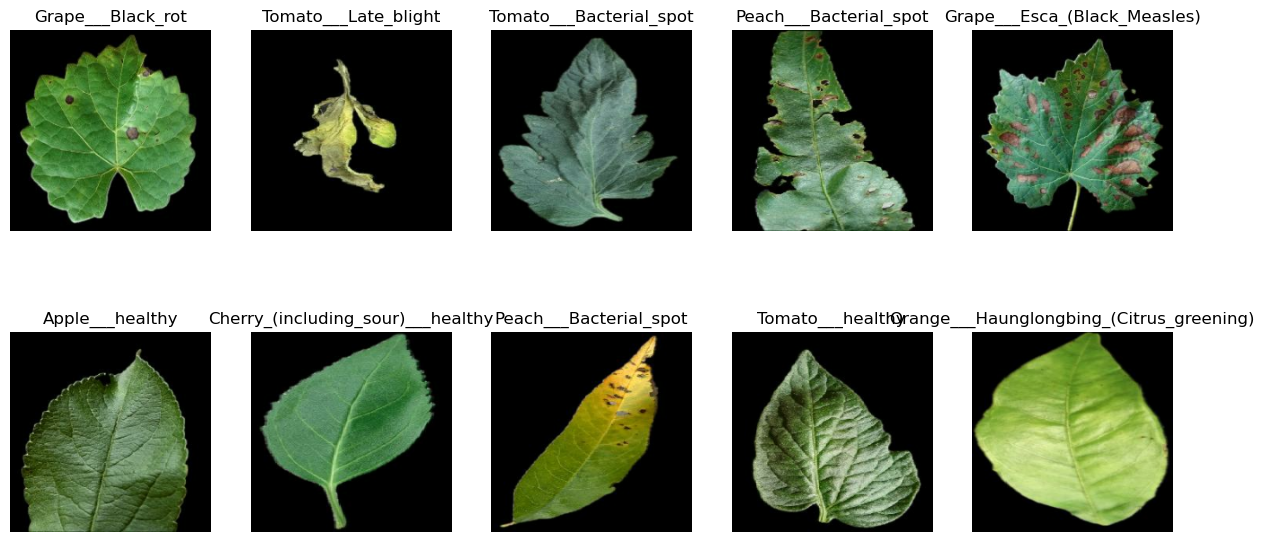

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
       for i in range(10): 
        ax = plt.subplot(4,5, i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80% ==> training
# 20% ==> 10% validation, 10% test
train_size = 0.8
len(dataset)*train_size

1448.8000000000002

In [8]:
train_ds = dataset.take(1449)
len(train_ds)

1449

In [9]:
test_ds = dataset.skip(1449)
len(test_ds)

362

In [10]:
val_size = 0.1
len(dataset)*val_size

181.10000000000002

In [11]:
val_ds = test_ds.take(182)
len(val_ds)

182

In [12]:
test_ds = dataset.skip(182)
len(test_ds)

1629

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size= len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
       
    train_size = int(train_split * ds_size)
        
    val_size = int(val_split * ds_size)
        
    train_ds = ds.take(train_size)
        
    val_ds = ds.skip(train_size).take(val_size)
        
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

1448

In [16]:
len(val_ds)

181

In [17]:
len(test_ds)

182

In [18]:
#optimiztion 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
def process_images(image_batch, label_batch):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image_batch = tf.image.per_image_standardization(image_batch)
    # Resize images from 32x32 to 277x277
    image_batch = tf.image.resize(image_batch, (227,227))
    return image_batch, label_batch

In [20]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [23]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer

In [24]:
def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [25]:
import os
import time
import tensorflow as tf
from tensorflow import keras
#root_logdir = os.path.join(os.curdir, "logs\\fit\\")

#def get_run_logdir():
 #   run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  #  return os.path.join(root_logdir, run_id)

#run_logdir = get_run_logdir()
#tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [26]:
model = googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

learning_rate = 0.005
decay_rate = learning_rate / 30
sgd = SGD(learning_rate=learning_rate, momentum=0.9, decay=decay_rate, nesterov=False)

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [28]:
history= model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
1448/1448 [==============================] - 750s 352ms/step - loss: 4.8129 - main_loss: 1.8039 - aux1_loss: 1.4024 - aux2_loss: 1.6067 - main_accuracy: 0.4822 - aux1_accuracy: 0.5927 - aux2_accuracy: 0.5392 - val_loss: 3.6356 - val_main_loss: 1.6397 - val_aux1_loss: 0.9234 - val_aux2_loss: 1.0725 - val_main_accuracy: 0.5221 - val_aux1_accuracy: 0.6976 - val_aux2_accuracy: 0.6564
Epoch 2/30
1448/1448 [==============================] - 358s 247ms/step - loss: 1.8504 - main_loss: 0.6966 - aux1_loss: 0.5409 - aux2_loss: 0.6129 - main_accuracy: 0.7768 - aux1_accuracy: 0.8267 - aux2_accuracy: 0.8061 - val_loss: 2.0999 - val_main_loss: 0.8323 - val_aux1_loss: 0.5741 - val_aux2_loss: 0.6935 - val_main_accuracy: 0.7280 - val_aux1_accuracy: 0.8144 - val_aux2_accuracy: 0.7726
Epoch 3/30
1448/1448 [==============================] - 273s 189ms/step - loss: 1.1343 - main_loss: 0.4098 - aux1_loss: 0.3393 - aux2_loss: 0.3852 - main_accuracy: 0.8677 - aux1_accuracy: 0.8897 - aux2_accuracy: 

1448/1448 [==============================] - 257s 177ms/step - loss: 0.0524 - main_loss: 0.0162 - aux1_loss: 0.0204 - aux2_loss: 0.0158 - main_accuracy: 0.9948 - aux1_accuracy: 0.9933 - aux2_accuracy: 0.9949 - val_loss: 0.0595 - val_main_loss: 0.0223 - val_aux1_loss: 0.0184 - val_aux2_loss: 0.0187 - val_main_accuracy: 0.9924 - val_aux1_accuracy: 0.9941 - val_aux2_accuracy: 0.9941161 - aux1_loss: 0.0206 - aux2_loss: 0.0159 - main_accuracy: 0.9948 - aux1_accuracy: 0.9932 - aux2
Epoch 20/30
1448/1448 [==============================] - 258s 178ms/step - loss: 0.0483 - main_loss: 0.0142 - aux1_loss: 0.0190 - aux2_loss: 0.0152 - main_accuracy: 0.9953 - aux1_accuracy: 0.9937 - aux2_accuracy: 0.9948 - val_loss: 0.2017 - val_main_loss: 0.0764 - val_aux1_loss: 0.0522 - val_aux2_loss: 0.0731 - val_main_accuracy: 0.9762 - val_aux1_accuracy: 0.9832 - val_aux2_accuracy: 0.9794
Epoch 21/30
1448/1448 [==============================] - 257s 178ms/step - loss: 0.0420 - main_loss: 0.0123 - aux1_loss: 0.0

In [29]:
model.evaluate(test_ds)

182/182 [==============================] - 130s 53ms/step - loss: 0.0672 - main_loss: 0.0263 - aux1_loss: 0.0191 - aux2_loss: 0.0218 - main_accuracy: 0.9949 - aux1_accuracy: 0.9960 - aux2_accuracy: 0.99630s - loss: 0.0688 - main_loss: 0.0268 - aux1_loss: 0.0196 - aux2_loss: 0.0224 - main_accuracy: 0.9949 - aux1_accuracy: 0.9959 - aux2_accuracy: 0.


[0.06719217449426651,
 0.0262987669557333,
 0.01910916157066822,
 0.021784234791994095,
 0.9948717951774597,
 0.9959706664085388,
 0.9963369965553284]

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

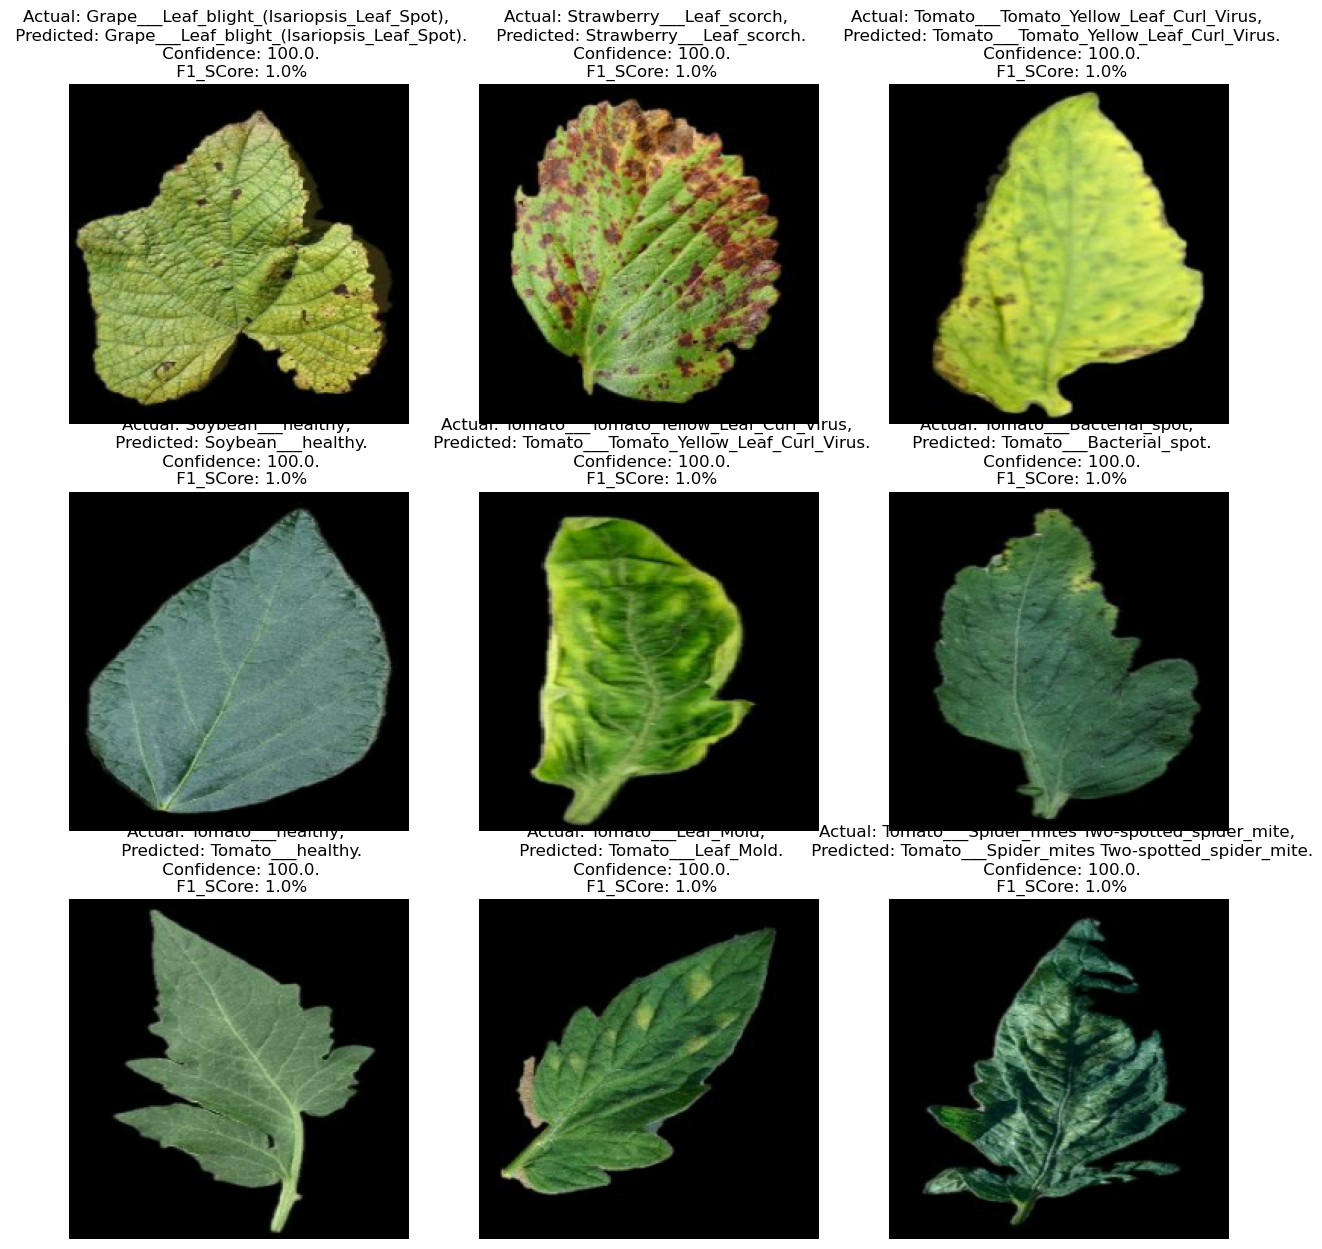

In [31]:
# 1st batch,9 images
import numpy as np
from sklearn.metrics import f1_score
over_all_actual_encoded = []
over_all_predicted_encoded = []

plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(10):

    for i in range(9):
        actualencoded = []
        predicted_encoded = []
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        predicted_encoded.append(encoded_class.get(predicted_class))
#         print(predict(model, image_batch[i].numpy()))
        actual_class = class_names[label_batch[i]]
        actualencoded.append(encoded_class.get(actual_class))
        over_all_actual_encoded.append(encoded_class.get(actual_class))
        over_all_predicted_encoded.append(encoded_class.get(predicted_class))
        f1 = f1_score(actualencoded,predicted_encoded,average = 'micro')
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}.\n F1_SCore: {f1}%")
        
        plt.axis("off")

In [32]:
f1_score(over_all_actual_encoded,over_all_predicted_encoded,average = 'micro')

1.0

In [33]:
model_version = 24
model.save(f"../model24/{model_version}")

INFO:tensorflow:Assets written to: ../model24/24\assets


In [34]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, "model_Google_segmented_V4_80_20.h5")